# Создание baseline-модели

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import sys, os
import pathlib
from pathlib import Path
import numpy as np

from olist_churn_prediction.paths import SRC_DIR, PROCESSED_DIR, INTERIM_NOTEBOOK_DIR, RAW_DIR
from olist_churn_prediction import feature_processing

from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_validate
from sklearn.metrics import f1_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.tracking import MlflowClient

In [2]:
mlflow.set_tracking_uri("file:///C:/Users/Вячеслав/Documents/olist_churn/olist-ml-churn-prediction/mlruns")
client = MlflowClient(tracking_uri="file:///C:/Users/Вячеслав/Documents/olist_churn/olist-ml-churn-prediction/mlruns")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_parquet(INTERIM_NOTEBOOK_DIR / "merged_churn_interim.parquet")

In [5]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93882 entries, 0 to 93881
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93882 non-null  string        
 1   order_products_value           93882 non-null  float32       
 2   order_freight_value            93882 non-null  float32       
 3   order_items_qty                93882 non-null  Int64         
 4   product_photos_qty             93882 non-null  Int64         
 5   product_name_lenght            93882 non-null  Float64       
 6   product_description_lenght     93882 non-null  Float64       
 7   review_creation_date           93882 non-null  datetime64[ns]
 8   review_answer_timestamp        93882 non-null  datetime64[ns]
 9   order_purchase_timestamp       93882 non-null  datetime64[ns]
 10  order_aproved_at               93882 non-null  datetime64[ns]
 11  order_estimated

None

## Выбор метрики и функции потерь

Задача: несбалансированная бинарная классификация. Обозначим потенциально полезные **метрики качества**:
1. **Precision**: TP/(TP + FP). Интерпретация: "FP в данном случае - клиенты, распознанные моделью как ушедшие, но на самом деле не ушли. Максимизация precision минимизирует количество таких клиентов". Полезна, когда нам очень важно не дать лишний раз скидку или бонус клиенту.
2. **Recall**: TP/(TP + FN). Интерпретация: "FN здесь - это клиенты, распознанные моделью как оставшиеся, но на самом деле ушедшие. Максимизация recall минимизирует количество таких клиентов". Полезна, когда очень важно различить всех потенциально ушедших клиентов (класс '1'). Хорошо подходит под нашу ситуацию.
3. **F1**: среднее гармоническое precision и recall. Когда одинаково важны обе метрики выше.
4. **ROC-AUC**. Покажет, насколько модель хорошо справляется по сравнению со случайной такой же моделью. Хороша как вспомогательная метрика.

Возможные **функции потерь**:
1. **Взвешенный BCE**: L = -α·y log p − (1−y) log(1−p). Базовая функция с небольшим дополнением в виде параметра α, регулирующим вес класса '1'.
2. **Focal loss**: L = -(1−p)^γ · y log p. Усиленно штрафуем трудные примеры (FN часто 'трудные'). Когда модель быстро учится на лёгких TN и 'забывает' про редкие TP.

Возьмем за основную метрику для максимизации recall, так как предполагается, что важнее не упустить потенциально ушедшего клиента, чем не дать лишних скидок. За функцию потерь возьмем BCE.

## Специфика проекта

Отношение ушедших клиентов к неушедшим: 8:1. К сожалению, невозможно проверить, является ли такое распределение типичным для компании Olist. Будем считать, что данные отражают действительность.

## Предобработка

In [6]:
df = df.rename(columns={'value': 'summary_payments_value',
                        'product_name_lenght': 'product_name_length',
                        'product_description_lenght': 'product_description_length'})

Разделим признаки по категориям:

In [7]:
target = ['churned'] # целевая переменная
ids_features = ['order_id', 'customer_id', 'customer_unique_id', 'product_id', 'review_id', 'seller_id', 'seller_zip_code_prefix', 'customer_zip_code_prefix'] # id-признаки
categorical_features = df.select_dtypes(include=["object", "string"]).columns.drop(ids_features).tolist() # категориальные признаки
numeric_features = df.select_dtypes(include=["int", "float"]).drop(target, axis=1).columns.tolist() # численные без target
time_features = df.select_dtypes(include=["datetime64[ns]"]).columns.tolist() # временные

Посмотрим количество уникальных категорий для некоторых признаков:

In [8]:
len(df['product_category_name_english'].value_counts())

71

In [9]:
len(df['customer_city'].value_counts())

4288

In [10]:
len(df['seller_city'].value_counts())

468

Без продвинутого кодирования (вроде TargetEncoding) мы не можем такие признаки обработать. Так как следующий этап - построение baseline-модели, то мы не можем сейчас применять сложные преобразования. Уберем эти признаки из baseline.

Heatmap корреляций:

In [11]:
corr_matrix = df[numeric_features].corr()

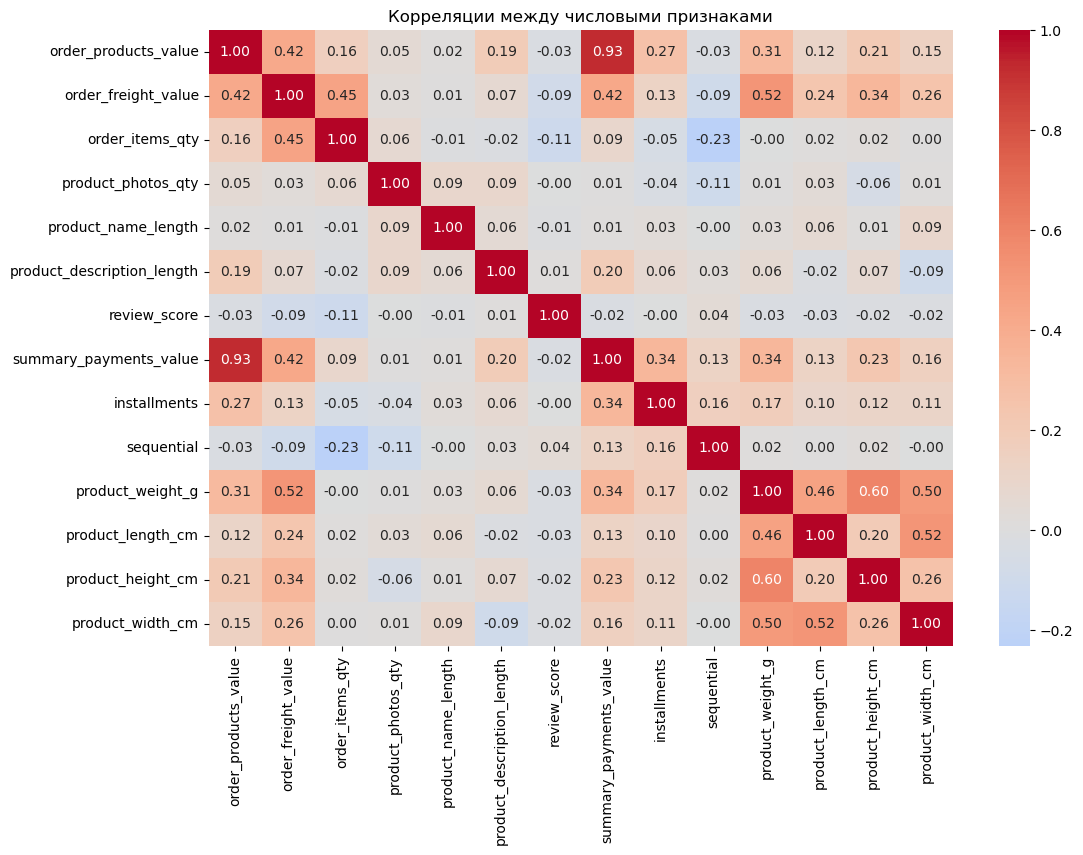

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляции между числовыми признаками")
plt.show()

Никаких неожиданных значений коэффициентов. Не имеет большого значения для моделей, улавливающих нелинейные зависимости.

## Построение baseline-модели

За признаки для baseline возьмем следующие:
1. Категориальные признаки, не требующие сложного кодирования;
2. Численные непрерывные;
4. Численные номинативные без большого количества категорий.

Не будем на данном этапе включать временные в любом виде, id-признаки, признаки с большим количеством категорий (> 30).

In [13]:
baseline_features = df[categorical_features + numeric_features].columns.drop(['customer_city', 'seller_city', 'product_category_name_english'])

In [14]:
df[baseline_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93882 entries, 0 to 93881
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_state              93882 non-null  string 
 1   seller_state                93882 non-null  string 
 2   order_products_value        93882 non-null  float32
 3   order_freight_value         93882 non-null  float32
 4   order_items_qty             93882 non-null  Int64  
 5   product_photos_qty          93882 non-null  Int64  
 6   product_name_length         93882 non-null  Float64
 7   product_description_length  93882 non-null  Float64
 8   review_score                93882 non-null  Int64  
 9   summary_payments_value      93882 non-null  float32
 10  installments                93882 non-null  Int64  
 11  sequential                  93882 non-null  Int64  
 12  product_weight_g            93882 non-null  float32
 13  product_length_cm           938

In [15]:
X = df[baseline_features]
y = df['churned']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
ohe_cols = ['customer_state', 'seller_state'] # признаки для OneHotEncoder

Будем применять конструкцию *sklearn.pipeline* для контроля и чистоты конвейера.

In [18]:
col_tf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True), ohe_cols)
    ]
)

Используем простейшую технику кодирования - OneHotEncoding. Это надежный способ кодирования для категориальных признаков с небольшим количеством категорий.

In [19]:
pipe  = Pipeline([('prep', col_tf),
                  ('clf',  RandomForestClassifier())])

В данном проекте используется библиотека *Mlflow* для контроля экспериментов и сохранения артефактов моделей.

In [41]:
mlflow.set_experiment("olist baseline") # название эксперимента

with mlflow.start_run(run_name="rf_baseline") as run: # старт эксперимента
    run_id = run.info.run_id
    scores = cross_validate(pipe, X_train, y_train,
                            cv=5,
                            scoring=['f1', 'recall', 'roc_auc'],
                            n_jobs=-1) # используем кросс-валидацию
    mlflow.log_metrics({
        "f1_mean":     scores['test_f1'].mean(),
        "recall_mean": scores['test_recall'].mean(),
        "roc_auc_mean":scores['test_roc_auc'].mean(),
    }) # берем средние метрики по фолдам кросс-валидации как финальные

    pipe.fit(X_train, y_train)
    #mlflow.sklearn.log_model(pipe, "model_full") # сохранение модели

2025/08/05 16:20:29 INFO mlflow.tracking.fluent: Experiment with name 'olist baseline' does not exist. Creating a new experiment.


Если понадобится вызвать определенный эксперимент для просмотра результатов, то можно воспользоваться run_id.

In [42]:
run = client.get_run(run_id)
params = run.data.params # параметры модели
print(run_id)
print(params)

51ffb177bb8642e1933a75ebe1010a3b
{}


Для получения всех проведенных ранее экспериментов существует конструкция ниже:

In [43]:
runs = mlflow.search_runs(order_by=["start_time DESC"])
runs[["run_id", "status", "start_time", "end_time"]]

,run_id,status,start_time,end_time
0,51ffb177bb8642e1933a75ebe1010a3b,FINISHED,2025-08-05 09:20:29.965000+00:00,2025-08-05 09:22:17.827000+00:00


Проверим еще раз вручную метрики:

In [45]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_res = cross_validate(pipe, X, y, cv=cv,
                        scoring=['f1', 'recall', 'precision', 'roc_auc'], return_train_score=False)

In [35]:
print('f1:  ', cv_res['test_f1'].mean())
print('recall:  ', cv_res['test_recall'].mean())
print('precision:  ', cv_res['test_precision'].mean())
print('roc_auc:  ', cv_res['test_roc_auc'].mean())

f1:   0.9471186993818058
recall:   0.9906324103868214
precision:   0.9072686792264598
roc_auc:   0.9057904112846099


Базовая модель дает подозрительно хорошие результаты для наших основных метрик. Это может являться следствием утечки данных. Так как мы не создавали новых признаков, а лишь применили масштабирование к численным и one-hot к категориальным, то проблема может крыться в преобладании некоторых отдельных признаков. Проверим feature_importances_.

In [20]:
pipe.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ohe', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [21]:
pipe_pred = pipe.predict(X_test)

In [22]:
f1_test = f1_score(y_test, pipe_pred)
recall_test = recall_score(y_test, pipe_pred)
roc_auc_test = roc_auc_score(y_test, pipe_pred)

In [23]:
print(f1_test)
print(recall_test)
print(roc_auc_test)

0.9472318083945374
0.9905613818630475
0.6766207766346791


In [27]:
rf_model = pipe.named_steps["clf"]
importances = rf_model.feature_importances_
feature_names = pipe.named_steps["prep"].get_feature_names_out()

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_imp.head(20))

                            feature  importance
1          num__order_freight_value    0.189854
7       num__summary_payments_value    0.115837
0         num__order_products_value    0.102534
5   num__product_description_length    0.081443
10            num__product_weight_g    0.067759
4          num__product_name_length    0.063910
12           num__product_height_cm    0.057547
13            num__product_width_cm    0.049554
11           num__product_length_cm    0.047286
8                 num__installments    0.042416
3           num__product_photos_qty    0.033831
6                 num__review_score    0.025227
39           ohe__customer_state_sp    0.011934
2              num__order_items_qty    0.010589
61             ohe__seller_state_sp    0.009535
24           ohe__customer_state_mg    0.008053
32           ohe__customer_state_rj    0.007562
31           ohe__customer_state_pr    0.005241
47             ohe__seller_state_mg    0.005177
54             ohe__seller_state_pr    0

Можно заметить небольшое преобладание признака `order_freight_value`, но он не является единственным значимым. Вывод: утечки данных нет, как и слишком важных признаков.

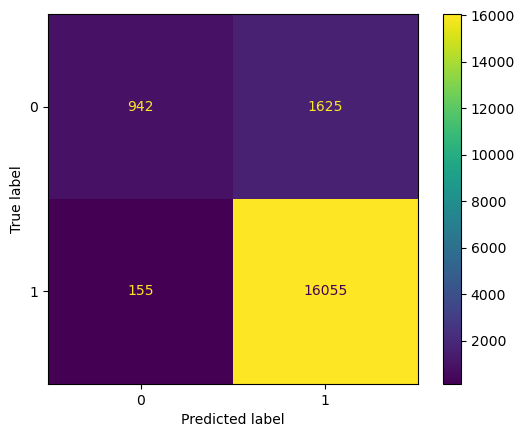

In [32]:
cm = confusion_matrix(y_test, pipe_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()
plt.show()

Матрица ошибок выглядит логически правильной: много примеров класса '1', следовательно модель хорошо обучается на этом классе. Нам важно высокое качество именно на классе '1', что мы и можем наблюдать по метрикам recall, f1 и confusion matrix.